# Reference
https://medium.com/eatpredlove/natural-cubic-splines-implementation-with-python-edf68feb57aa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
sys.version

'3.8.3 (default, Jul  2 2020, 16:21:59) \n[GCC 7.3.0]'

In [3]:
def jacobi(A, b, x0, tol, n_iterations=300):
    """
    Performs Jacobi iterations to solve the line system of
    equations, Ax=b, starting from an initial guess, ``x0``.
    
    Returns:
    x, the estimated solution
    """
    
    n = A.shape[0]
    #print("n: ", n)
    x = x0.copy()
    x_prev = x0.copy()
    counter = 0
    x_diff = tol+1
    
    while (x_diff > tol) and (counter < n_iterations): #iteration level
        for i in range(0, n): #element wise level for x
            s = 0
            for j in range(0,n): #summation for i !=j
                if i != j:
                    s += A[i,j] * x_prev[j] 
                    #print("s: ",s)
            x[i] = (b[i] - s) / A[i,i]
            #print("x{:d}: {:.3f} {:.3f} {:.3f} {:.3f}".format(i, x[i], b[i,0], A[i,i], s))
        #update values
        counter += 1
        #print("sum_of_elems", np.sum((x-x_prev)))
        x_diff = (np.sum((x-x_prev)**2))**0.5 
        #print("x_diff: ", x_diff)
        x_prev = x.copy() #use new x for next iteration
        
    
    print("Number of Iterations: ", counter)
    print("Norm of Difference: ", x_diff)
    return x

In [4]:
def cubic_spline(x, y, tol = 1e-100):
    """
    Interpolate using natural cubic splines.
    
    Generates a strictly diagonal dominant matrix then applies Jacobi's method.
    
    Returns coefficients:
    b, coefficient of x of degree 1
    c, coefficient of x of degree 2
    d, coefficient of x of degree 3
    """ 
    x = np.array(x)
    y = np.array(y)
    ### check if sorted
    if np.any(np.diff(x) < 0):
        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]

    size = len(x)
    delta_x = np.diff(x)
    delta_y = np.diff(y)
    #for i in zip(delta_x, delta_y):
    #    print("{:.3f}, {:.3f}".format(i[0], i[1]))
        
    ### Get matrix A
    A = np.zeros(shape = (size,size))
    b = np.zeros(shape=(size,1))
    A[0,0] = 1
    A[-1,-1] = 1
    
    for i in range(1,size-1):
        A[i, i-1] = delta_x[i-1]
        A[i, i+1] = delta_x[i]
        A[i,i] = 2*(delta_x[i-1]+delta_x[i])
        
    ### Get matrix b
        b[i,0] = 3*(delta_y[i]/delta_x[i] - delta_y[i-1]/delta_x[i-1])
        #print("A - {:.3f} {:.3f} {:.3f}, b - {:.3f}".format(A[i, i-1], A[i, i+1],  A[i,i], b[i,0]))
        
    ### Solves for c in Ac = b
    print('Jacobi Method Output:')
    c = jacobi(A, b, np.zeros(len(A)), tol = tol, n_iterations=1000)
    
    ### Solves for d and b
    d = np.zeros(shape = (size-1,1))
    b = np.zeros(shape = (size-1,1))
    for i in range(0,len(d)):
        d[i] = (c[i+1] - c[i]) / (3*delta_x[i])
        b[i] = (delta_y[i]/delta_x[i]) - (delta_x[i]/3)*(2*c[i] + c[i+1])    
    
    return b.squeeze(), c.squeeze(), d.squeeze()

In [5]:
# 구해진 polynomial parameter를 이용해 polynomial 식 구현 (1,2차 미분 포함)
def cubic_polynomial(xk, yk, bk, ck, dk, x):
    delta_x = x-xk
    x = yk + bk*delta_x + ck*delta_x*delta_x + dk*delta_x*delta_x*delta_x
    dx = bk + 2*ck*delta_x + 3*dk*delta_x*delta_x
    ddx = 2*ck + 6*dk*delta_x
    return x, dx, ddx

In [6]:
def check_poly_num(t, ts):
    num=0
    for i in range(len(ts)):
        if t>=ts[i]:
            num+=1
    return num

In [7]:
readfile = open("CameraPath_20Hz.txt", 'r')
lines = readfile.readlines()

x0 = float(lines[0].split('\n')[0].split(',')[1])
y0 = float(lines[0].split('\n')[0].split(',')[2])
print(x0, y0)

xs = []
ys = []
ts = []

sampling_freq = 100

cnt = 0
for line in lines:
    cnt +=1
    item = line.split('\n')[0].split(',')
    time, x, y, z, w, rx, ry, rz = item
    if cnt%sampling_freq == 0:
        ts.append(float(time))
        xs.append(-(float(x)-x0))
        ys.append(-(float(y)-y0))

9.39567 1.3212


In [8]:
ts

[4.950001,
 9.95002,
 14.95004,
 19.94998,
 24.94991,
 29.94983,
 34.94975,
 39.94968,
 44.9496,
 49.94952,
 54.94945,
 59.94937]

In [9]:
xs

[-0.0,
 2.294310000000001,
 4.3182350000000005,
 5.469638000000001,
 5.469638000000001,
 8.00491,
 9.628383800000002,
 11.102338000000001,
 12.348058000000002,
 12.348058000000002,
 14.635023,
 16.473501]

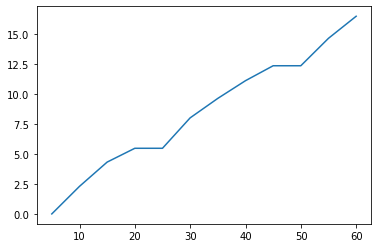

In [10]:
plt.plot(ts, xs)

In [11]:
total_time = ts[len(ts)-1] -ts[0]
time = []
q = []
dq = []
ddq = []

b, c, d = cubic_spline(ts, xs, 0)

Jacobi Method Output:
Number of Iterations:  51
Norm of Difference:  0.0


In [12]:
for i in zip(b, c, d):
    print("{:.3f}, {:.3f}, {:.3f}".format(i[0], i[1], i[2]))

0.468, 0.000, -0.000
0.440, -0.006, -0.000
0.361, -0.010, -0.003
0.020, -0.058, 0.011
0.251, 0.104, -0.011
0.497, -0.055, 0.004
0.258, 0.008, -0.000
0.330, 0.007, -0.005
0.052, -0.062, 0.010
0.207, 0.093, -0.009
0.490, -0.037, 0.002


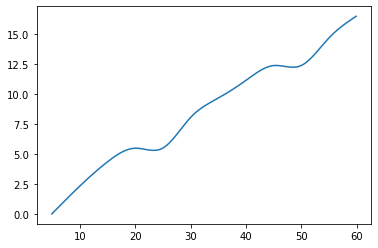

In [13]:
for i in range(1000):
    t = total_time/1000.0*i+ts[0]
    num = check_poly_num(t,ts)
    if num < len(ts):
        x, dx, ddx = cubic_polynomial(ts[num-1], xs[num-1], b[num-1], c[num-1], d[num-1], t)
        time.append(t)
        q.append(x)
        dq.append(dx)
        ddq.append(ddx)

plt.plot(time, q)

In [17]:
for i in zip(q, dq, ddq):
    print("{:.3f}, {:.3f}, {:.3f}".format(i[0], i[1], i[2]))

0.000, 0.468, 0.000
0.026, 0.468, -0.000
0.051, 0.468, -0.000
0.077, 0.468, -0.000
0.103, 0.468, -0.000
0.129, 0.468, -0.001
0.154, 0.468, -0.001
0.180, 0.468, -0.001
0.206, 0.468, -0.001
0.232, 0.468, -0.001
0.257, 0.468, -0.001
0.283, 0.468, -0.001
0.309, 0.468, -0.001
0.335, 0.468, -0.002
0.360, 0.467, -0.002
0.386, 0.467, -0.002
0.412, 0.467, -0.002
0.437, 0.467, -0.002
0.463, 0.467, -0.002
0.489, 0.467, -0.002
0.514, 0.467, -0.002
0.540, 0.467, -0.003
0.566, 0.466, -0.003
0.591, 0.466, -0.003
0.617, 0.466, -0.003
0.643, 0.466, -0.003
0.668, 0.466, -0.003
0.694, 0.466, -0.003
0.720, 0.465, -0.003
0.745, 0.465, -0.004
0.771, 0.465, -0.004
0.796, 0.465, -0.004
0.822, 0.465, -0.004
0.847, 0.464, -0.004
0.873, 0.464, -0.004
0.898, 0.464, -0.004
0.924, 0.464, -0.004
0.949, 0.464, -0.005
0.975, 0.463, -0.005
1.000, 0.463, -0.005
1.026, 0.463, -0.005
1.051, 0.462, -0.005
1.077, 0.462, -0.005
1.102, 0.462, -0.005
1.128, 0.462, -0.005
1.153, 0.461, -0.005
1.178, 0.461, -0.006
1.204, 0.461, 

## 직선 예제

Jacobi Method Output:
Number of Iterations:  1
Norm of Difference:  0.0


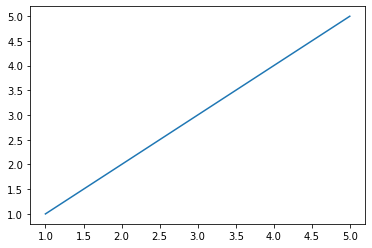

In [15]:
ts = [1, 2, 3, 4, 5]
xs = [1, 2, 3, 4, 5]

total_time = ts[len(ts)-1] -ts[0]
time = []
theta = []

b, c, d = cubic_spline(ts, xs)

for i in range(1000):
    t = total_time/1000.0*i+ts[0]
    num = check_poly_num(t,ts)
    #print(t)
    if num < len(ts):
        x, dx, ddx = cubic_polynomial(ts[num-1], xs[num-1], b[num-1], c[num-1], d[num-1], t)
        time.append(t)
        theta.append(x)

plt.plot(time, theta)

## 곡선

Jacobi Method Output:
Number of Iterations:  37
Norm of Difference:  0.0


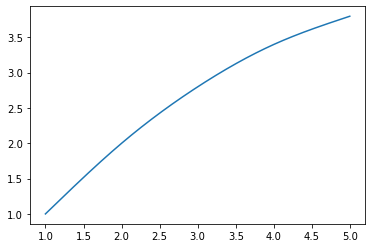

In [16]:
ts = [1, 2, 3, 4, 5]
#xs = [1, 1.8, 2.4, 2.8, 3]
xs = [1, 2, 2.8, 3.4, 3.8]

total_time = ts[len(ts)-1] -ts[0]
time = []
theta = []

b, c, d = cubic_spline(ts, xs)

for i in range(1000):
    t = total_time/1000.0*i+ts[0]
    num = check_poly_num(t,ts)
    
    if num < len(ts):
        x, dx, ddx = cubic_polynomial(ts[num-1], xs[num-1], b[num-1], c[num-1], d[num-1], t)
        time.append(t)
        theta.append(x)
        #print(t, num, x, dx, ddx)

plt.plot(time, theta)